# DNN 정형데이터 템플릿 - 이진분류/이상탐지(0/1) 완전체
시험장에서 **컬럼명만 바꾸고 복붙**해서 바로 돌릴 수 있게 만든 3교시용 템플릿입니다.

## 🎯 공통 평가 포인트(출제 의도)
- 데이터 탐색(결측/분포/불균형) → 전처리(범주/수치) → DNN 학습 → 지표 평가 → (분류면) 운영 정책/리포트
- 과적합 방지(드롭아웃/weight decay/validation)
- (가산) 간단 해석(오차 상위 샘플/Confusion matrix/정책 기반 리포트)

## ✅ 시험장에서 바꾸는 곳(필수 3개)
- `CSV_PATH` (토이데이터 대신 실제 CSV)
- `target_col`
- `cat_cols` (범주형 리스트)
나머지는 거의 그대로 사용 가능.


## 0) Imports & 재현성

In [1]:
import os, random, warnings, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

warnings.filterwarnings("ignore")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

## 1) 토이데이터 생성 (이진분류/이상탐지)
예시 컨셉: 제조 배치 불량 예측 `eol_fail` (0 정상, 1 불량)

- 불균형(약 4%)
- 포함 요소: 결측 + 이상치 + 미세 신호


In [2]:
def make_toy_binary(n=25000, pos_ratio=0.04, seed=42):
    rng = np.random.default_rng(seed)

    line_id = rng.integers(1, 7, size=n).astype(str)
    shift = rng.choice(["day","swing","night"], size=n, p=[0.5,0.3,0.2])
    supplier = rng.choice(["A","B","C","D","E"], size=n, p=[0.25,0.25,0.2,0.2,0.1])
    material_grade = rng.choice(["G1","G2","G3"], size=n, p=[0.55,0.35,0.10])

    temp = rng.normal(70, 5, size=n) + (line_id.astype(int)-3)*0.7
    pressure = np.abs(rng.normal(1.1, 0.35, size=n))
    vibration = np.abs(rng.normal(3.0, 1.0, size=n)) + (shift=="night")*0.6
    humidity = np.clip(rng.normal(45, 10, size=n), 10, 90)
    cycle_time = rng.normal(120, 15, size=n) + (material_grade=="G3")*7
    error_cnt = rng.poisson(1.3, size=n) + (supplier=="E")*1

    risk = (
        0.9*np.maximum(0, vibration-3.5)
        + 1.2*np.maximum(0, error_cnt-2)
        + 0.03*np.maximum(0, cycle_time-130)
        + (supplier=="E")*0.7
        + (material_grade=="G3")*0.8
        + ((supplier=="C") & (shift=="night"))*0.6
        + rng.normal(0, 0.3, size=n)
    )
    thr = np.quantile(risk, 1-pos_ratio)
    y = (risk >= thr).astype(int)

    df = pd.DataFrame({
        "line_id": line_id,
        "shift": shift,
        "supplier": supplier,
        "material_grade": material_grade,
        "temp": temp,
        "pressure": pressure,
        "vibration": vibration,
        "humidity": humidity,
        "cycle_time": cycle_time,
        "error_cnt": error_cnt,
        "eol_fail": y
    })

    for col in ["temp","pressure","humidity"]:
        m = rng.random(n) < 0.02
        df.loc[m, col] = np.nan

    o = rng.random(n) < 0.005
    df.loc[o, "vibration"] *= 5
    df.loc[o, "error_cnt"] += 15
    return df

df = make_toy_binary()
df.head()


,line_id,shift,supplier,material_grade,temp,pressure,vibration,humidity,cycle_time,error_cnt,eol_fail
0,1,swing,B,G2,72.201846,1.611765,3.355289,37.261277,129.428981,1,0
1,5,day,C,G3,63.364482,0.855629,2.114496,38.691957,114.966993,0,0
2,4,day,B,G1,71.581965,0.867188,2.301938,58.566909,79.426107,0,0
3,3,night,C,G2,79.701367,0.797913,4.521331,44.411507,123.758695,1,0
4,3,swing,C,G1,72.990901,1.714678,3.042883,54.778454,108.307165,3,0


## 2) 데이터 탐색(EDA): 크기/결측/타깃 분포

Shape: (25000, 11)

Target counts:
eol_fail
0    24000
1     1000
Name: count, dtype: int64

Target ratio:
eol_fail
0    0.96
1    0.04
Name: proportion, dtype: float64

Missing ratio top:
humidity          0.02084
pressure          0.01964
temp              0.01908
supplier          0.00000
shift             0.00000
line_id           0.00000
material_grade    0.00000
vibration         0.00000
cycle_time        0.00000
error_cnt         0.00000
dtype: float64


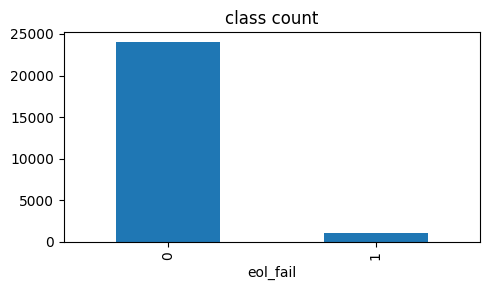

In [3]:
target_col = "eol_fail"
cat_cols = ["line_id","shift","supplier","material_grade"]
num_cols = [c for c in df.columns if c not in cat_cols + [target_col]]

print("Shape:", df.shape)
print("\nTarget counts:")
print(df[target_col].value_counts())
print("\nTarget ratio:")
print(df[target_col].value_counts(normalize=True))

print("\nMissing ratio top:")
print(df.isna().mean().sort_values(ascending=False).head(10))

plt.figure(figsize=(5,3))
df[target_col].value_counts().plot(kind="bar", title="class count")
plt.tight_layout()
plt.show()


## 3) Split & 전처리(범주형/수치형)

In [4]:
X = df[cat_cols + num_cols].copy()
y = df[target_col].copy()
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

USE_ROBUST = True
scaler = RobustScaler() if USE_ROBUST else StandardScaler()

cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])
num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc", scaler)
])
preprocess = ColumnTransformer([
    ("cat", cat_pipe, cat_cols),
    ("num", num_pipe, num_cols),
])

X_train_enc = preprocess.fit_transform(X_train)
X_val_enc = preprocess.transform(X_val)

X_train_dense = X_train_enc.toarray() if hasattr(X_train_enc, "toarray") else np.asarray(X_train_enc)
X_val_dense = X_val_enc.toarray() if hasattr(X_val_enc, "toarray") else np.asarray(X_val_enc)

print("Dense shapes:", X_train_dense.shape, X_val_dense.shape)


Dense shapes: (20000, 23) (5000, 23)


## 4) PyTorch Dataset/DataLoader

In [5]:
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)  # 0/1
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_ds = TabularDataset(X_train_dense, y_train.astype(int))
val_ds = TabularDataset(X_val_dense, y_val.astype(int))

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=512, shuffle=False)


## 5) DNN 모델 + 손실/가중치(불균형 대응)

In [6]:
in_dim = X_train_dense.shape[1]
out_dim = 1

class DNN(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, out_dim),
        )
    def forward(self, x):
        return self.net(x)

model = DNN(in_dim, out_dim).to(device)

pos = int((y_train==1).sum())
neg = int((y_train==0).sum())
pos_weight = torch.tensor([neg / max(pos, 1)], dtype=torch.float32, device=device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
print("pos_weight:", pos_weight.item())

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)


pos_weight: 24.0


## 6) 학습/평가 루프

In [7]:
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve, f1_score, precision_score, recall_score

def eval_val():
    model.eval()
    val_loss = 0.0
    n = 0
    logits_all = []
    y_all = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device); yb = yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item() * len(xb)
            n += len(xb)
            logits_all.append(logits.cpu().numpy())
            y_all.append(yb.cpu().numpy())
    logits_all = np.vstack(logits_all).ravel()
    y_all = np.vstack(y_all).ravel()
    y_prob = 1/(1+np.exp(-logits_all))
    pr_auc = average_precision_score(y_all, y_prob)
    roc_auc = roc_auc_score(y_all, y_prob)
    return val_loss / n, y_all, y_prob, pr_auc, roc_auc

best_pr = -1
best_state = None
EPOCHS = 20

for epoch in range(1, EPOCHS+1):
    model.train()
    tr_loss = 0.0
    n = 0
    for xb, yb in train_loader:
        xb = xb.to(device); yb = yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        tr_loss += loss.item() * len(xb)
        n += len(xb)

    val_loss, y_true, y_prob, pr_auc, roc_auc = eval_val()
    if pr_auc > best_pr:
        best_pr = pr_auc
        best_state = {k:v.cpu().clone() for k,v in model.state_dict().items()}

    if epoch % 5 == 0 or epoch == 1:
        print(f"epoch {epoch:02d} | train_loss {tr_loss/n:.4f} | val_loss {val_loss:.4f} | PR-AUC {pr_auc:.4f} | ROC-AUC {roc_auc:.4f}")

model.load_state_dict(best_state)
print("Best PR-AUC:", best_pr)


epoch 01 | train_loss 0.7275 | val_loss 0.3683 | PR-AUC 0.6761 | ROC-AUC 0.9824
epoch 05 | train_loss 0.2448 | val_loss 0.1912 | PR-AUC 0.8805 | ROC-AUC 0.9940
epoch 10 | train_loss 0.1638 | val_loss 0.1549 | PR-AUC 0.9166 | ROC-AUC 0.9959
epoch 15 | train_loss 0.1477 | val_loss 0.1425 | PR-AUC 0.9324 | ROC-AUC 0.9964
epoch 20 | train_loss 0.1339 | val_loss 0.1267 | PR-AUC 0.9358 | ROC-AUC 0.9969
Best PR-AUC: 0.9410541576133925


## 7) 이진분류 출력(필수): PR-AUC + 임계값 정책 + 리포트

In [8]:
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve, f1_score, precision_score, recall_score

# 확률(score)
model.eval()
with torch.no_grad():
    logits = model(torch.tensor(X_val_dense, dtype=torch.float32, device=device)).cpu().numpy().ravel()
y_prob = 1/(1+np.exp(-logits))
y_true = y_val.values.astype(int)

print("PR-AUC:", average_precision_score(y_true, y_prob))
print("ROC-AUC:", roc_auc_score(y_true, y_prob))

# 임계값 정책
prec, rec, ths = precision_recall_curve(y_true, y_prob)
f1s = 2*prec*rec/(prec+rec+1e-12)

idx = np.argmax(f1s)
th_f1 = ths[idx] if idx < len(ths) else 0.5
th_top5 = np.percentile(y_prob, 95)

TARGET_RECALL = 0.90
valid = np.where(rec[:-1] >= TARGET_RECALL)[0]
th_recall = th_f1
if len(valid) > 0:
    idx_c = valid[np.argmax(prec[valid])]
    th_recall = ths[idx_c]

def eval_at(th):
    y_pred = (y_prob >= th).astype(int)
    return {
        "threshold": float(th),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "alarm_rate": float(y_pred.mean())
    }

print("F1-opt:", eval_at(th_f1))
print("Top5% :", eval_at(th_top5))
print("Recall>=%.2f:"%TARGET_RECALL, eval_at(th_recall))

# Top5% 리포트(상위 30건)
val_report = X_val.copy()
val_report["score"] = y_prob
val_report["y_true"] = y_true
val_report.sort_values("score", ascending=False).head(30)


PR-AUC: 0.9410541576133925
ROC-AUC: 0.9967510416666667
F1-opt: {'threshold': 0.8857760429382324, 'precision': 0.855072463768116, 'recall': 0.885, 'f1': 0.8697788697788698, 'alarm_rate': 0.0414}
Top5% : {'threshold': 0.7732675075531006, 'precision': 0.748, 'recall': 0.935, 'f1': 0.8311111111111111, 'alarm_rate': 0.05}
Recall>=0.90: {'threshold': 0.8688613772392273, 'precision': 0.8411214953271028, 'recall': 0.9, 'f1': 0.8695652173913043, 'alarm_rate': 0.0428}


,line_id,shift,supplier,material_grade,temp,pressure,vibration,humidity,cycle_time,error_cnt,score,y_true
9533,4,day,A,G1,68.715704,1.545584,1.427530,31.900957,118.316203,6,0.999915,1
9081,1,night,E,G1,69.485102,NaN,2.299717,50.319012,141.485024,6,0.999907,1
22949,1,swing,B,G1,67.376450,1.242892,1.228853,41.906317,123.403848,6,0.999873,1
5002,4,day,C,G3,70.764087,1.959999,2.338397,NaN,165.006163,6,0.999864,1
5713,4,day,E,G3,67.340155,1.287183,3.162685,41.512991,111.377343,7,0.999792,1
8606,2,night,E,G2,70.723756,1.327514,2.035557,48.676289,131.939209,5,0.999780,1
2263,4,day,E,G1,71.474477,1.115289,2.342756,37.884124,127.035460,5,0.999752,1
2359,2,day,E,G2,69.869855,0.845972,1.447530,50.337805,103.129043,5,0.999740,1
8472,3,day,B,G2,65.409783,1.302413,2.330636,38.777533,115.674174,6,0.999715,1
10867,3,day,B,G3,75.296434,0.981711,2.574223,49.417076,145.068474,6,0.999680,1


## 8) 시험장 복붙 체크리스트(초압축)
1) `CSV_PATH` 로딩 → `target_col`, `cat_cols` 지정  
2) `num_cols` 자동 생성 확인  
3) 전처리(OHE+Scaler) → dense 변환  
4) DNN 학습(Adam + dropout + weight_decay)  
5) 회귀: MAE/RMSE / 이진: PR-AUC+임계값 / 다중: macroF1+confusion  
6) 리포트 출력(TopN/오차상위/확신상위)까지 하면 점수 잘 나옴
